In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

from data import GraphMatrixDataset, CNNMatrixDataset
from utils import P300Getter, train_model, plot_sample, show_progress
from interpretation import *
from models_cnn import *
from models_gnn import *
from graph import get_delaunay_graph, get_pos_init_graph, plot_graph, get_neighbors_graph
import run_exp
import regularization

In [3]:
import mne
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from scipy.spatial import Delaunay
import networkx as nx
import scipy.sparse as sp
import time
from sklearn.neighbors import NearestNeighbors

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage, DigMontage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import Scaler

from torch_geometric.data import Data, InMemoryDataset

import wandb
import pickle

In [4]:
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import os

import pathlib

In [5]:
from IPython.display import clear_output

In [6]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')

print(device)

cuda:0


In [7]:
DATA_PATH = pathlib.Path(r'C:\Users\Vladimir\PycharmProjects\EEGPatternRecognition\matrix_dataset')

train_A_raw = scipy.io.loadmat(DATA_PATH / 'Subject_A_Train.mat')
test_A_raw = scipy.io.loadmat(DATA_PATH / 'Subject_A_Test.mat')

eloc = mne.channels.read_custom_montage(DATA_PATH / 'eloc64.txt')
info = mne.create_info(ch_names=eloc.ch_names, ch_types=['eeg'] * 64, sfreq=240)

train_A_chars = list(train_A_raw['TargetChar'][0])
test_A_chars = list('WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU')

A_train_ds = P300Getter(train_A_raw, eloc, sample_size=72)
A_test_ds = P300Getter(test_A_raw, eloc, sample_size=72, target_chars=test_A_chars)

A_train_ds.get_cnn_p300_dataset(filter=True)
A_test_ds.get_cnn_p300_dataset(filter=True)

A_train_ds.upsample(4)
#A_test_ds.upsample(2)

X_train_A, y_train_A = A_train_ds.get_data()
X_test_A, y_test_A = A_test_ds.get_data()

clear_output()
print("Success")

Success


In [8]:
train_A_dataset = CNNMatrixDataset(tensors=(X_train_A, y_train_A), with_target=True, transform=None)
test_A_dataset = CNNMatrixDataset(tensors=(X_test_A, y_test_A), with_target=True, transform=None)

batch_size = 1024

train_A_CNN = DataLoader(train_A_dataset, batch_size=batch_size, shuffle=True)
test_A_CNN = DataLoader(test_A_dataset, batch_size=batch_size, shuffle=True)

data_loaders_CNN = {'train':train_A_CNN, 'val':test_A_CNN}

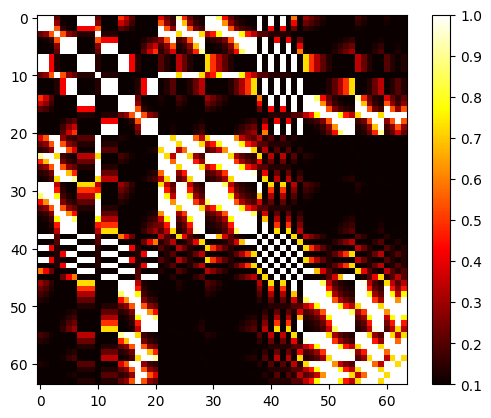

In [9]:
plt.imshow(get_pos_init_graph(eloc), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [10]:
positions = eloc.get_positions()['ch_pos']
points = np.stack(list(positions.values()))
ch_names = dict(enumerate(positions.keys()))

In [11]:
torch.manual_seed(44)
np.random.seed(44)

A_init = torch.empty(64, 64)
k = math.sqrt(1 / (64 * 64))
nn.init.uniform_(A_init, -k, k)
A_init = (A_init + A_init.T) / 2

A_init

tensor([[ 6.8622e-03,  1.0667e-02,  3.4481e-03,  ..., -2.1118e-03,
          5.2476e-03,  9.8840e-03],
        [ 1.0667e-02,  5.4418e-04,  3.9523e-03,  ...,  2.1553e-03,
          6.6262e-03,  3.1635e-04],
        [ 3.4481e-03,  3.9523e-03, -6.8051e-03,  ...,  1.0208e-04,
         -5.5562e-04,  3.8470e-03],
        ...,
        [-2.1118e-03,  2.1553e-03,  1.0208e-04,  ...,  1.4679e-02,
          2.0596e-03,  1.4644e-04],
        [ 5.2476e-03,  6.6262e-03, -5.5562e-04,  ...,  2.0596e-03,
         -1.1903e-02,  2.9926e-03],
        [ 9.8840e-03,  3.1635e-04,  3.8470e-03,  ...,  1.4644e-04,
          2.9926e-03,  9.0171e-06]])

In [12]:
learning_params = {
    # 'num_epochs' : 500,
    'num_epochs' : 150,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

In [ ]:
torch.manual_seed(44)
np.random.seed(44)

A = SymLinear(A_init.clone())
A.requires_grad_(False)
model_GNN = BaseGNN(48, 64, A)

train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=device, run_name='sym-random-const')

clear_output()
print("Success")

In [ ]:
torch.manual_seed(44)
np.random.seed(44)

A = SymLinear(A_init.clone())
A.requires_grad_(True)
model_GNN = BaseGNN(48, 64, A)

train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=device, run_name='sym-random-const')

clear_output()
print("Success")

In [21]:
A_trained = model_GNN.adj.base_mat.detach().cpu()
A_trained.requires_grad = False

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_19252\1741604943.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.abs(A_trained - A_init) / torch.sum(np.abs(A_trained - A_init)),


<Axes: >

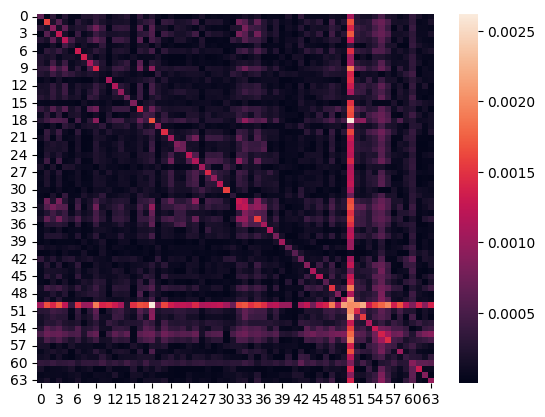

In [34]:
sns.heatmap(
    np.abs(A_trained - A_init) / torch.sum(np.abs(A_trained - A_init)),
)

In [ ]:
torch.manual_seed(44)
np.random.seed(44)

A = SymLinear(A_init.clone())
A.requires_grad_(True)
model_GNN = BaseGNN(48, 64, A)
hybrid_criterion = HybridLoss([
    {'func': criterion, 'kwargs_list': ['input', 'target']},
    {'func': L1Reg(gamma=0.0), 'kwargs_list': ['adj']}
])

train_model(
    model=model_GNN, 
    dataloaders=data_loaders_CNN, 
    criterion=hybrid_criterion, 
    learning_params=learning_params, 
    device=device, 
    run_name='sym-random-test'
    )

In [ ]:
A_res_l1 = []

for gamma in np.logspace(-5, 0, num=6, base=10):
    torch.manual_seed(44)
    np.random.seed(44)

    A = SymLinear(A_init.clone())
    A.requires_grad_(True)
    model_GNN = BaseGNN(48, 64, A)
    hybrid_criterion = HybridLoss([
        {'func': criterion, 'kwargs_list': ['input', 'target']},
        {'func': L1Reg(gamma=gamma), 'kwargs_list': ['adj']}
    ])

    train_model(
        model=model_GNN, 
        dataloaders=data_loaders_CNN, 
        criterion=hybrid_criterion, 
        learning_params=learning_params, 
        device=device, 
        run_name=f'sym-random-l1-g{gamma:.5f}'
        )
    
    A_res_l1.append(
        model_GNN.adj.base_mat.detach().cpu()
    )

clear_output()
print("Success")

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_22228\1924926636.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained - A_init),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_22228\1924926636.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained - A_init),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_22228\1924926636.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained - A_init),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_22228\1924926636.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained - A_init),
C:\Users\Vladimir\AppData\Local\Temp

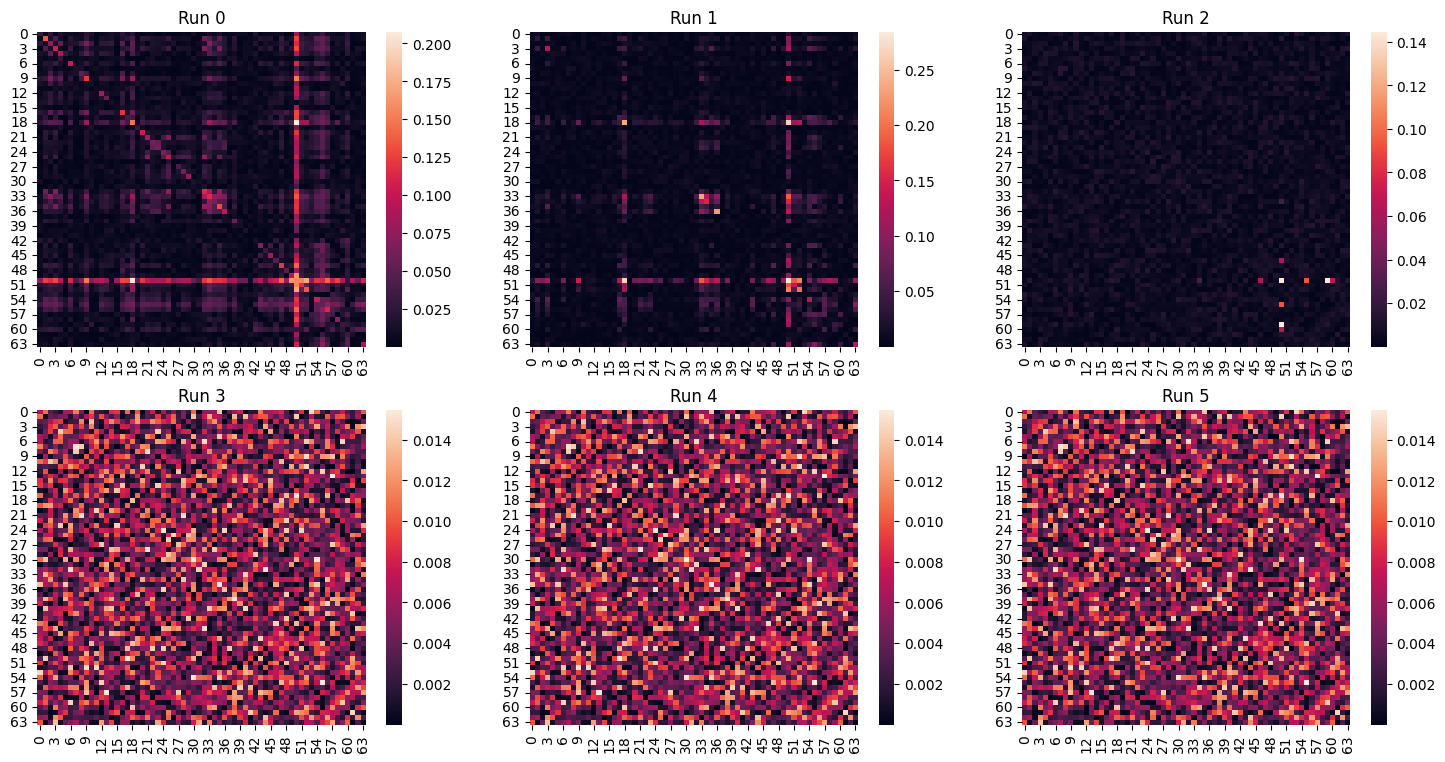

In [22]:
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 9))

for idx, A_trained in enumerate(A_res_l1):
    i, j = divmod(idx, 3)
    sns.heatmap(
        data=np.abs(A_trained - A_init),
        ax=ax[i, j],
        # norm=LogNorm()
    )
    ax[i, j].set_title(f'Run {idx}')

In [43]:
# with open('../A_res_l1_dump.bin', 'wb') as f:
#     pickle.dump(
#         obj=A_res_l1,
#         file=f
#     )

In [ ]:
A_res_nuc = []

for gamma in np.logspace(-5, 0, num=6, base=10):
    torch.manual_seed(44)
    np.random.seed(44)

    A = SymLinear(A_init.clone())
    A.requires_grad_(True)
    model_GNN = BaseGNN(48, 64, A)
    hybrid_criterion = HybridLoss([
        {'func': criterion, 'kwargs_list': ['input', 'target']},
        {'func': NuclearReg(gamma=gamma), 'kwargs_list': ['adj']}
    ])

    train_model(
        model=model_GNN, 
        dataloaders=data_loaders_CNN, 
        criterion=hybrid_criterion, 
        learning_params=learning_params, 
        device=device, 
        run_name=f'sym-random-nuc-g{gamma:.5f}'
        )
    
    A_res_nuc.append(
        model_GNN.adj.base_mat.detach().cpu()
    )

clear_output()
print("Success")

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_22228\3860455009.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained - A_init),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_22228\3860455009.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained - A_init),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_22228\3860455009.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained - A_init),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_22228\3860455009.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained - A_init),
C:\Users\Vladimir\AppData\Local\Temp

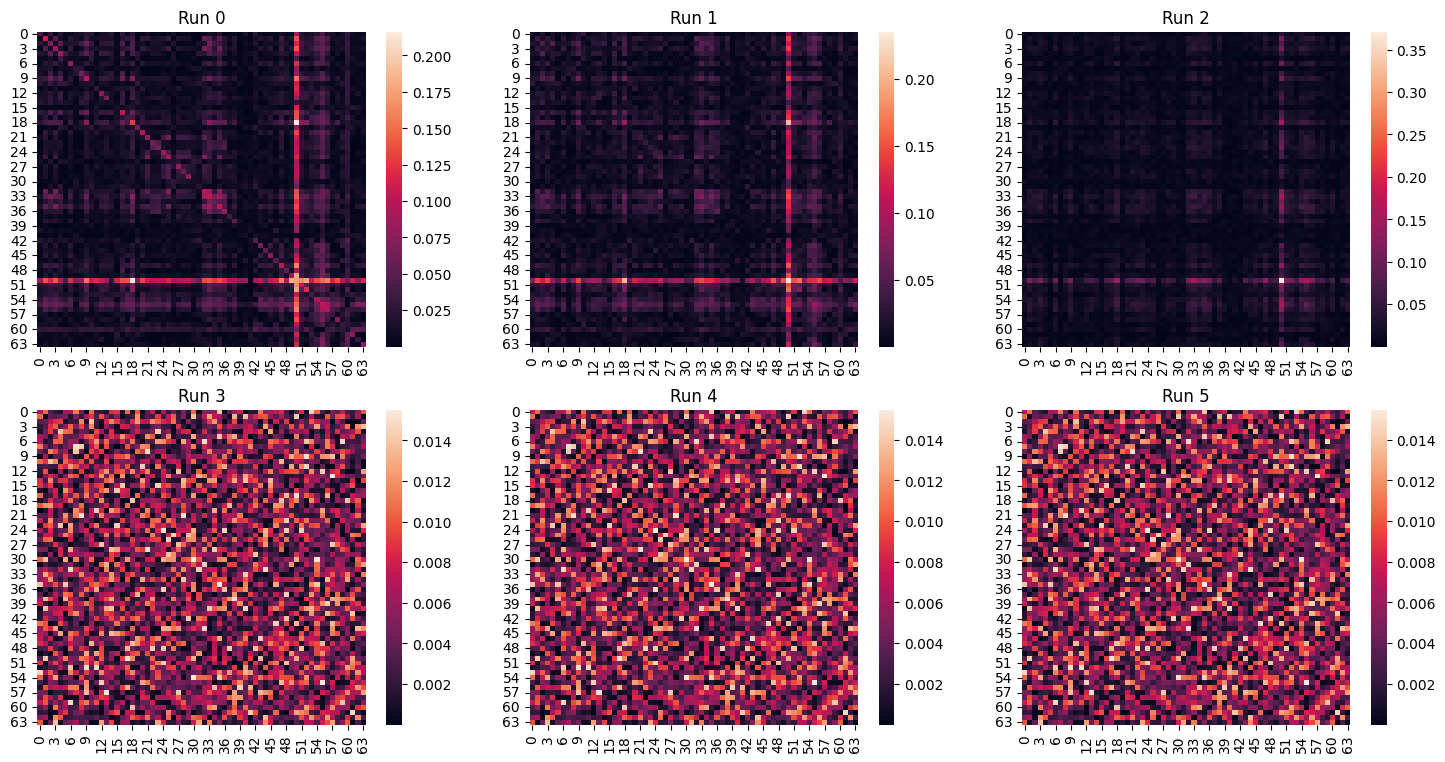

In [26]:
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 9))

for idx, A_trained in enumerate(A_res_nuc):
    i, j = divmod(idx, 3)
    sns.heatmap(
        data=np.abs(A_trained - A_init),
        ax=ax[i, j],
        # norm=LogNorm()
    )
    ax[i, j].set_title(f'Run {idx}')

<Axes: >

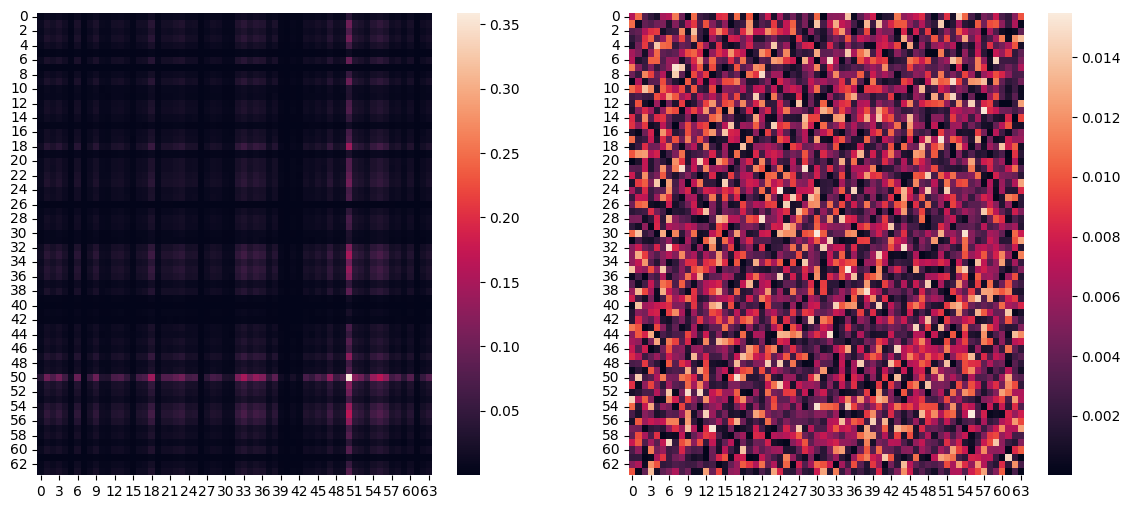

In [39]:
_, ax = plt.subplots(ncols=2, figsize=(14, 6))

sns.heatmap(
    data=torch.abs(A_res_nuc[2]),
    ax=ax[0],
    # norm=LogNorm()
)

sns.heatmap(
    data=torch.abs(A_init),
    ax=ax[1],
    # norm=LogNorm()
)

In [41]:
# with open('../A_res_nuc_dump.bin', 'wb') as f:
#     pickle.dump(
#         obj=A_res_nuc,
#         file=f
#     )

In [17]:
A = SymLinear(torch.zeros_like(A_init))
A.requires_grad_(False)
model_GNN = BaseGNN(48, 64, A)
hybrid_criterion = HybridLoss([
    {'func': criterion, 'kwargs_list': ['input', 'target']},
])

train_model(
    model=model_GNN, 
    dataloaders=data_loaders_CNN, 
    criterion=hybrid_criterion, 
    learning_params=learning_params, 
    device=device, 
    run_name=f'sym-zero-const'
)

clear_output()
print("Success")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bogachevv. Use `wandb login --relogin` to force relogin


  0%|          | 0/500 [00:00<?, ?it/s]

train/epoch_acc,▁▁▂▂▃▃▄▄▄▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████
train/epoch_bc,▁▂▃▄▄▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train/epoch_f1,▁▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█████████████████
train/epoch_ones,▁▇▇▇▇███████████████████████████████████
train/epoch_precision,▁▁▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████
train/epoch_recall,▁▂▂▂▃▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▆▆▇▇▇▇▇▇▇▇▇▇████
train/loss,██▇▇▇▇▇▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
train/max_acc,▁▁▂▂▃▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
train/min_acc,▁▁▂▂▂▃▃▃▄▄▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█████
val/epoch_acc,▁▁▁▂▂▄▅▇▇▇▇▇▇▇▇█▇▇▇▇▇█▇▇▇█▇▇▇██▇████▇███
val/epoch_bc,▁▁▂▂▂▅▆▇▇▇▇▇█████████████████████████▇▇▇


In [18]:
A = SymLinear(torch.zeros_like(A_init))
A.requires_grad_(True)
model_GNN = BaseGNN(48, 64, A)
hybrid_criterion = HybridLoss([
    {'func': criterion, 'kwargs_list': ['input', 'target']},
])

train_model(
    model=model_GNN, 
    dataloaders=data_loaders_CNN, 
    criterion=hybrid_criterion, 
    learning_params=learning_params, 
    device=device, 
    run_name=f'sym-zero-learnable'
    )

clear_output()
print("Success")

Success


In [19]:
A_res_nuc = []

for gamma in np.logspace(-5, 0, num=6, base=10):
    torch.manual_seed(44)
    np.random.seed(44)

    A = SymLinear(torch.zeros_like(A_init))
    A.requires_grad_(True)
    model_GNN = BaseGNN(48, 64, A)
    hybrid_criterion = HybridLoss([
        {'func': criterion, 'kwargs_list': ['input', 'target']},
        {'func': NuclearReg(gamma=gamma), 'kwargs_list': ['adj']}
    ])

    train_model(
        model=model_GNN, 
        dataloaders=data_loaders_CNN, 
        criterion=hybrid_criterion, 
        learning_params=learning_params, 
        device=device, 
        run_name=f'sym-zero-nuc-g{gamma:.5f}'
        )
    
    A_res_nuc.append(
        model_GNN.adj.base_mat.detach().cpu()
    )

clear_output()
print("Success")

Success


In [20]:
with open('../A_zero_nuc_dump.bin', 'wb') as f:
    pickle.dump(
        obj=A_res_nuc,
        file=f
    )

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_9040\4102124541.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_9040\4102124541.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_9040\4102124541.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_9040\4102124541.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_9040\4102124541.py:6: Depreca

Text(0.5, 0.98, 'Zero initialization, nuclear regularization')

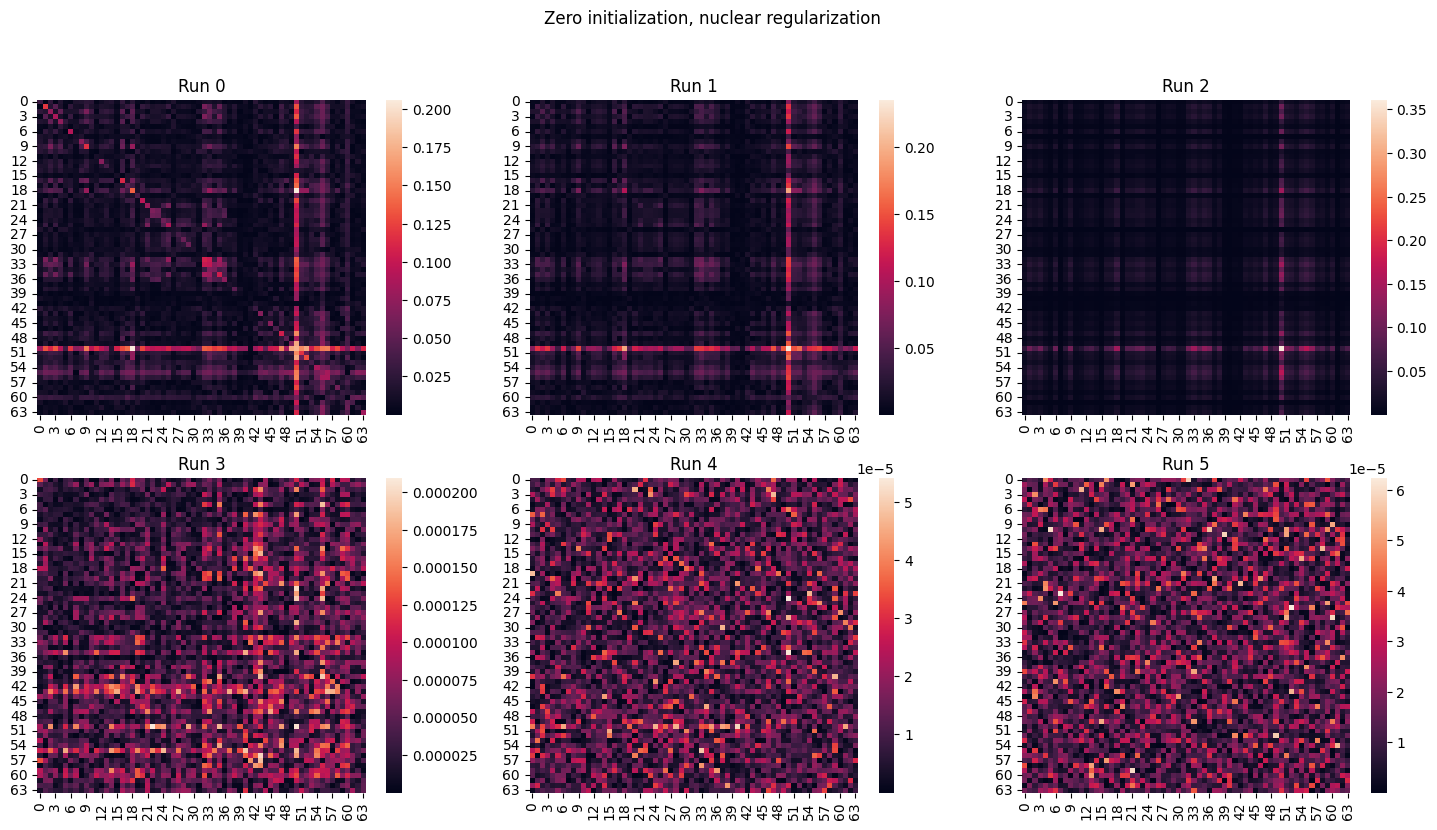

In [25]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 9))

for idx, A_trained in enumerate(A_res_nuc):
    i, j = divmod(idx, 3)
    sns.heatmap(
        data=np.abs(A_trained
                    
                    
                    
                    
                    
                    
              
                    ),
        ax=ax[i, j],
        # norm=LogNorm()
    )
    ax[i, j].set_title(f'Run {idx}')









 123



fig.supkljklk;l
title('Zero initialization, nuclear regularization')

In [ ]:
A_res_acyclic = run_exp.run(
    run_name_fmt='sym-zero-acyclic-g{0}',
    reg_cls=regularization.AcyclicReg,
    gamma_grid=np.logspace(-5, 0, num=6, base=10),
    A_init=torch.zeros_like(A_init),
    data_loaders=data_loaders_CNN,
    learning_params=learning_params,
    device=device
)

In [13]:
A_res_acyclic = run_exp.run(
    run_name_fmt='sym-random-acyclic-g{0}',
    reg_cls=regularization.AcyclicReg,
    gamma_grid=[1.0, 10.0, 100.0],
    A_init=A_init,
    data_loaders=data_loaders_CNN,
    learning_params=learning_params,
    device=device
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bogachevv. Use `wandb login --relogin` to force relogin


  0%|          | 0/150 [00:00<?, ?it/s]

train/A_grad,▄▂▂▁▁▂▂▁▁▂▂▂▂▂▁▃▂▃▄▂▃▃▃▂▅▅▇▄▅█▅▃▅▃▃▄▄▅▅▆
train/epoch_acc,▁▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████████████████
train/epoch_bc,▁▁▂▃▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
train/epoch_f1,▁▁▄▄▅▆▆▇▇▇▇▇▇▇▇█▇▇██████████████████████
train/epoch_ones,▄▃█▇█▆▆▄▅▅▆▅▃▃▅▄▃▄▃▃▄▃▃▄▃▃▃▃▂▃▄▃▃▃▁▁▄▂▂▂
train/epoch_precision,▁▂▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇█████████████████
train/epoch_recall,▁▅▅▆▇▇▇▇▇█████▇▇▇▇█▇███▇████████████████
train/loss,█▇▇▆▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/max_acc,▁▂▃▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
train/min_acc,▁▂▂▃▄▆▇▇▇▇▇▇▇▇▇██▇██████████████████████
val/epoch_acc,█▁▁▁▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▆▆▆▇▇▇▇▇▇▇


  0%|          | 0/150 [00:00<?, ?it/s]

train/A_grad,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▁▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▂
train/epoch_acc,▁▂▃▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
train/epoch_bc,▁▂▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇██████████
train/epoch_f1,▁▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████▇███████████████
train/epoch_ones,▁▂▇▆█▇█▇▇▇▇▇▇▆▆▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▅▆▆▆▆▆▆▆▆▆
train/epoch_precision,▁▂▃▄▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██████████
train/epoch_recall,▁▄▅▅▇▇▇▇████████████████████████████████
train/loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/max_acc,▁▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇████████████████████
train/min_acc,▁▁▂▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
val/epoch_acc,▁▂▂▃▅▆▆▆▆▆▆▆▇▇▇▇▇▇█████▇████████████████


  0%|          | 0/150 [00:00<?, ?it/s]

train/A_grad,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_acc,▁▂▄▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train/epoch_bc,▁▂▂▃▄▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
train/epoch_f1,▁▂▃▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
train/epoch_ones,▁▄▃▄▅▆▇█▇██▇▇█▇▆▆▇▆▇▇▆▇▆▆▆▆▆▅▆▆▆▆▆▅▇▅▆▆▆
train/epoch_precision,▁▂▃▃▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
train/epoch_recall,▁▂▂▃▃▅▅▆▅▆▆▆▆▆▇▇▇▇▇▆▇▇▇▇▇▇▇▆▇▇▇▇▇█▇▇█▇██
train/loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/max_acc,▁▁▂▂▃▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
train/min_acc,▁▂▃▃▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
val/epoch_acc,▁▁▁▃▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██▇██████


C:\Users\Vladimir\AppData\Local\Temp\ipykernel_11344\3738213948.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained - A_init),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_11344\3738213948.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained - A_init),
C:\Users\Vladimir\AppData\Local\Temp\ipykernel_11344\3738213948.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data=np.abs(A_trained - A_init),


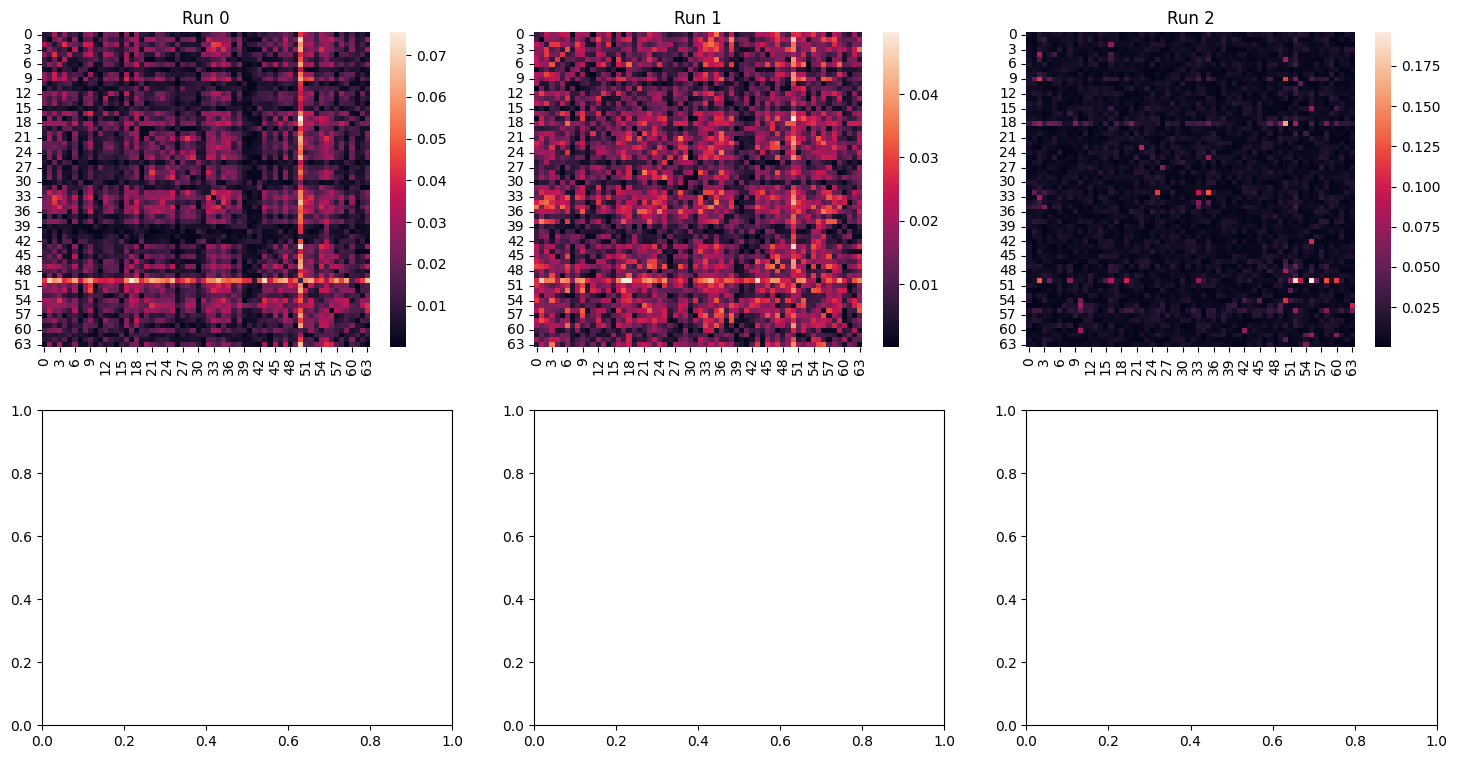

In [23]:
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 9))

for idx, A_trained in enumerate(A_res_acyclic):
    i, j = divmod(idx, 3)
    sns.heatmap(
        data=np.abs(A_trained - A_init),
        ax=ax[i, j],
        # norm=LogNorm()
    )
    ax[i, j].set_title(f'Run {idx}')